In [10]:
from nbodykit.lab import *
from nbodykit import style, setup_logging

import corner
from tqdm import tqdm
import numpy as np
# import seaborn as sns
import MAS_library as MASL
import Pk_library as PKL
import matplotlib.pyplot as plt
import random

import sys, pickle, time, os
# sys.path.insert(1, './')
from run_nbk_dict import COSMOPAR, order_dimension, order_folders, cosmological_pars, \
                         VarCosmoPar, fiducial_vals
from run_nbk_funcs import cosmo_parser, PacMan, Hartlap, error_message

# nbodykit tool to read custom (non-standard) catalogue file type
from nbodykit.io.base import FileType
# nbodykit tool to creae custom subclass od CatalogSource
from nbodykit.source.catalog.file import FileCatalogFactory
from nbodykit.source.catalog import BinaryCatalog
# nbodykit cosmology parameters initialization
from nbodykit.lab import cosmology, FFTPower

from readfof import FoF_catalog
from torch import flatten, from_numpy

from run_nbk_funcs import cosmo_parser, PacMan, Hartlap, HubblePar, covariation_matrix, error_message
from nbodykit.lab import cosmology

In [5]:
number_coeff_pk = 320
files_to_proecss = os.listdir('../Pk-files/')

In [6]:
nfile_fiducial, nfile_fiducial_rsd = "a", "a"
nfile_fiducial_no_W, nfile_fiducial_rsd_no_W = "a", "a"

for i in range(len(files_to_proecss)):
    fn = files_to_proecss[i]
    if ("fiducial" in fn) and ("rsd" not in fn) and ("W" not in fn): nfile_fiducial = fn
    if ("fiducial" in fn) and ("rsd"     in fn) and ("W" not in fn): nfile_fiducial_rsd = fn
    if ("fiducial" in fn) and ("rsd" not in fn) and ("W" not in fn): nfile_fiducial_no_W = fn
    if ("fiducial" in fn) and ("rsd"     in fn) and ("W" not in fn): nfile_fiducial_rsd_no_W = fn

assert type(nfile_fiducial) == type(nfile_fiducial_rsd) == str

fiducial_pk = []
fiducial_rsd_pk = []
fiducial_pk_no_W = []
fiducial_rsd_pk_no_W = []

with open("../Pk-files/"+nfile_fiducial, "rb") as f:
    while True:
        try:
            fiducial_pk.append(pickle.load(f))
        except EOFError:
            break

with open("../Pk-files/"+nfile_fiducial_rsd, "rb") as f:
    while True:
        try:
            fiducial_rsd_pk.append(pickle.load(f))
        except EOFError:
            break

with open("../Pk-files/"+nfile_fiducial_no_W, "rb") as f:
    while True:
        try:
            fiducial_pk_no_W.append(pickle.load(f))
        except EOFError:
            break

with open("../Pk-files/"+nfile_fiducial_rsd_no_W, "rb") as f:
    while True:
        try:
            fiducial_rsd_pk_no_W.append(pickle.load(f))
        except EOFError:
            break

In [7]:
fiducial_pk_pk, fiducial_rsd_pk_pk = [], []
for i in range(len(fiducial_pk)):
    fiducial_pk_pk.append(fiducial_pk[i]["power"].real  )# - fiducial_pk[i].attrs['shotnoise'] )
    fiducial_rsd_pk_pk.append(fiducial_rsd_pk[i]["power"].real )# - fiducial_rsd_pk[i].attrs['shotnoise'] )

fiducial_pk_pk_no_W, fiducial_rsd_pk_pk_no_W = [], []
for i in range(len(fiducial_pk)):
    fiducial_pk_pk_no_W.append(fiducial_pk_no_W[i]["power"].real )# - fiducial_pk[i].attrs['shotnoise'] )
    fiducial_rsd_pk_pk_no_W.append(fiducial_rsd_pk_no_W[i]["power"].real )# - fiducial_rsd_pk[i].attrs['shotnoise'] )

fiducial_pk_mean = np.mean(fiducial_pk_pk, axis=0)
fiducial_rsd_pk_mean = np.mean(fiducial_rsd_pk_pk, axis=0)
fiducial_pk_mean_no_W = np.mean(fiducial_pk_pk_no_W, axis=0)
fiducial_rsd_pk_mean_no_W = np.mean(fiducial_rsd_pk_pk_no_W, axis=0)

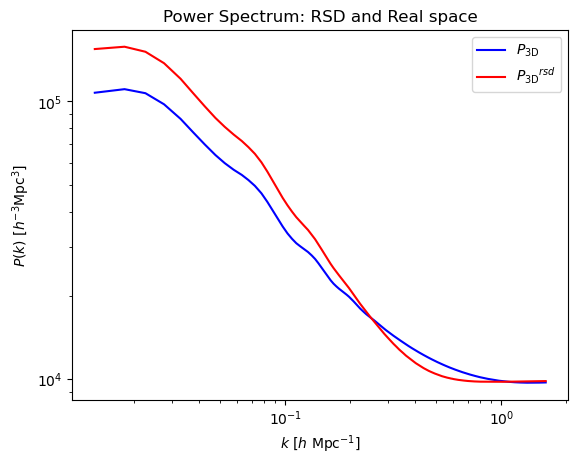

<Figure size 1500x1000 with 0 Axes>

In [9]:
plt.loglog(fiducial_pk[0]['k'], fiducial_pk_mean, label=r"$P_\mathrm{3D}$", color="b")
plt.loglog(fiducial_pk[0]['k'], fiducial_rsd_pk_mean, label=r"${P_\mathrm{3D}}^{rsd}$", color="r")

# format the axes
plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.title("Power Spectrum: RSD and Real space")
#plt.xlim(0.06, 0.9)
plt.figure(figsize=(15, 10));
# plt.savefig('Power_Spectrum_rsd_real_space.png', format='png');

In [11]:
def xy_distance(v, u):
    return np.sqrt((v-u)[0]**2 + (v-u)[1]**2)

def r_distance(s, p):
    assert np.shape(s) == np.shape(p), "arguments must be of the same size"
    # if type(s) == type(p) == float: return np.sqrt(s**2 + p**2)
    # elif np.shape(s) == (3,): return np.linalg.norm(s+p)
    # elif len(s[0]) == 3:
    #     a = []
    #     for i in range(len(a)): a.append(r_distance(s[i], p[i]))
    #     return np.array(a)
    # else:
    #     assert False, "problem with arguments, check" + str(np.shape(s)) + " " + str(np.shape(p))
    return np.sqrt(s**2 + p**2)

def integrand_xi(Pk, k, r):
    # assert np.shape(k * Pk * np.sin(k*r) / r) == (1), np.shape(k * Pk * np.sin(k*r) / r)
    return k * Pk * np.sin(k*r) / r

def corr_func(r, Pk, k_array):
    integral = 0.
    for i in range(len(Pk)-1):
        integral += ( integrand_xi(Pk=Pk[i+1], k=k_array[i+1], r=r) - integrand_xi(r=r, Pk=Pk[i], k=k_array[i]) )\
                  * (k_array[i+1]-k_array[i]) /2
    return np.abs(integral/(2*np.pi**2))

In [16]:
snapdir = "/media/fuffolo97/HDD1/UNI/Tesi/Halos/fiducial/10"
snapnum = 2
z_dict = {4:0.0, 3:0.5, 2:1.0, 1:2.0, 0:3.0}
redshift = z_dict[snapnum]

datas = FoF_catalog(snapdir, snapnum, read_IDs=False)

pos_h = (datas.GroupPos  / 1e3 ).astype(np.float32)                   # positions in Mpc/h
mass  = (datas.GroupMass * 1e10).astype(np.float32)                   # masses in M_sun/
vel   = (datas.GroupVel  * (1.0+redshift)).astype(np.float32)         # Halo peculiar velocities in km/s

H_cosmo = HubblePar(z = redshift, O_m = fiducial_vals["Om"], H_0 = fiducial_vals["h"], w = fiducial_vals["w"])
# print(H_cosmo)
assert H_cosmo > 0
pos_rsd = []
for i in range(len(vel)):
    pos_rsd.append(PacMan(pos_h[i] + (1+redshift) * np.array( ([0, 0, vel[i][2]/ H_cosmo ]) ) ))
pos_rsd = np.array(pos_rsd, dtype=np.float32)

In [17]:
BoxDim = 1000
dtype_cust = [
    ("Position", (np.float32, 3)),
    ("RSDPosition", (np.float32, 3)),
    ("Velocity", (np.float32, 3)),
    ("Mass", np.float32)]
N_mesh = 512

with open('./data_source_elsb.dat', "wb") as ff:
    pos_h.tofile(ff); pos_rsd.tofile(ff); vel.tofile(ff); mass.tofile(ff)
    ff.seek(0)

# create nbodykit BinaryCatalog
binCat = BinaryCatalog(ff.name, dtype_cust)

# create mesh
mesh = binCat.to_mesh(
  resampler='tsc', Nmesh=N_mesh,
  position='Position', weight="Mass",
  compensated=True,  # deconvolving
  interlaced=True,   # antialiasing
  BoxSize=BoxDim
)
mesh_rsd = binCat.to_mesh(
  resampler='tsc', Nmesh=N_mesh,
  compensated=True,  # deconvolving
  interlaced=True,   # antialiasing
  position='RSDPosition', weight="Mass",
  BoxSize=BoxDim
)

In [22]:
df = np.load('../df_m_256_CIC_z=0.npy').astype(np.float32)

In [24]:
mesh = ArrayMesh(df, BoxSize=1000)
FFTPower(mesh, mode='1d')

In [18]:
r = FFTPower(mesh, mode='1d', dk=0.005, kmin=0.01)
r_rsd = FFTPower(mesh_rsd, mode='1d', dk=0.005, kmin=0.01)

Pk = r.power["power"].real
Pk_rsd = r_rsd.power["power"].real
k = r.power["k"]

In [19]:
x, y = [], []
for i in tqdm(range(len(pos_h))):
    for j in range(len(pos_h)):
        if j>i:
            x.append(xy_distance(pos_h[i], pos_h[j]))
            y.append(np.abs(pos_h[i][2] - pos_h[j][2]))

  0%|          | 234/195602 [06:44<93:54:09,  1.73s/it] 


KeyboardInterrupt: 